# Week 6 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [38]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [39]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [41]:
dataDir = '../../data/grimmerPressReleases'

senReleasesDF = pandas.read_csv('senReleasesDF_raw.csv')
# senReleasesDF = pandas.DataFrame()

# for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
#     senPath = os.path.join(dataDir, senatorName)
#     senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)
# senReleasesDF.to_csv('senReleasesDf_raw.csv')
senReleasesDF[:100:10]

,Unnamed: 0,category,filePath,text
0,0,Klobuchar,../../data/grimmerPressReleases/Klobuchar/22Ma...,...
10,10,Klobuchar,../../data/grimmerPressReleases/Klobuchar/22Au...,...
20,20,Klobuchar,../../data/grimmerPressReleases/Klobuchar/17Ju...,...
30,30,Klobuchar,../../data/grimmerPressReleases/Klobuchar/14De...,...
40,40,Klobuchar,../../data/grimmerPressReleases/Klobuchar/22Ja...,...
50,50,Klobuchar,../../data/grimmerPressReleases/Klobuchar/28Ma...,...
60,60,Klobuchar,../../data/grimmerPressReleases/Klobuchar/27Ju...,...
70,70,Klobuchar,../../data/grimmerPressReleases/Klobuchar/01No...,...
80,80,Klobuchar,../../data/grimmerPressReleases/Klobuchar/24Ja...,...
90,90,Klobuchar,../../data/grimmerPressReleases/Klobuchar/23Ja...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [57]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF = pandas.read_csv('coha.csv')


#limit df to 1950 and 2009
senReleasesDF = senReleasesDF.query('year == 1930')
print(senReleasesDF.shape)
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(str(x))])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF.to_csv('coha_normtokens.csv')
# # senReleasesDF = pandas.read_csv('coha_norm.csv')
senReleasesDF[:100:10]

(267, 6)


,Unnamed: 0,id,category,year,filename,text,tokenized_sents,normalized_sents
3420,3420,164826\n,MAG,1930,mag_1930_164826.txt,In Abo ( the capital of Finland is Helsingfors...,"[[In, Abo, the, capital, of, Finland, is, Hels...","[[abo, capital, finland, helsingfors], [recent..."
3430,3430,164836\n,MAG,1930,mag_1930_164836.txt,If a new process devised by John Woods Beckman...,"[[If, a, new, process, devised, by, John, Wood...","[[new, process, devised, john, woods, beckman,..."
3440,3440,164846\n,MAG,1930,mag_1930_164846.txt,Last week a train drew into Youngstown . Ohio ...,"[[Last, week, a, train, drew, into, Youngstown...","[[week, train, drew, youngstown], [ohio, beari..."
3450,3450,164931\n,MAG,1930,mag_1930_164931.txt,"Last week , the Josiah Macy Jr . Fund , create...","[[Last, week, the, Josiah, Macy, Jr, Fund, cre...","[[week, josiah, macy, jr, fund, created, month..."
3460,3460,165723\n,MAG,1930,mag_1930_165723.txt,The U. S. Department of Agriculture bought its...,"[[The, U., S., Department, of, Agriculture, bo...","[[u., s., department, agriculture, bought, bar..."
3470,3470,165733\n,MAG,1930,mag_1930_165733.txt,Of no significance was the annual revival of t...,"[[Of, no, significance, was, the, annual, revi...","[[significance, annual, revival, oyster, busin..."
3480,3480,166316\n,MAG,1930,mag_1930_166316.txt,"SNOWDEN , Briand and Stresemann were the "" Big...","[[SNOWDEN, Briand, and, Stresemann, were, the,...","[[snowden, briand, stresemann, big, hague, rep..."
3490,3490,166326\n,MAG,1930,mag_1930_166326.txt,"Dsseldorf is grimy , hard and real , a city of...","[[Dsseldorf, is, grimy, hard, and, real, a, ci...","[[dsseldorf, grimy, hard, real, city, working,..."
3500,3500,166336\n,MAG,1930,mag_1930_166336.txt,Familiar is the story of the small merchant wh...,"[[Familiar, is, the, story, of, the, small, me...","[[familiar, story, small, merchant, unable, me..."
3510,3510,254999\n,MAG,1930,mag_1930_254999.txt,( See front cover ) <P> It is humidly hot in S...,"[[See, front, cover, <], [P], [>], [It, is, hu...","[[cover, <], [p], [>], [humidly, hot, sumatra,..."


In [58]:
senReleasesDF.dtypes

Unnamed: 0           int64
id                  object
category            object
year                 int64
filename            object
text                object
tokenized_sents     object
normalized_sents    object
dtype: object

In [59]:
senReleasesDF.iloc[0]
senReleasesDF.iloc[0]['tokenized_sents']


[['In', 'Abo', 'the', 'capital', 'of', 'Finland', 'is', 'Helsingfors'],
 ['recently',
  'the',
  'Civic',
  'Council',
  'decreed',
  'the',
  'total',
  'suppression',
  'of',
  'horn',
  'nuisance',
  'made',
  'it',
  'a',
  'misdemeanor',
  'for',
  'motorists',
  'to',
  'give',
  'audible',
  'signs',
  'of',
  'their',
  'approach'],
 ['<', 'P'],
 ['>',
  'News',
  'of',
  'this',
  'deed',
  'flashed',
  'to',
  'the',
  'capital',
  'of',
  'Norway',
  'Beautiful',
  'Oslo'],
 ['fired',
  'members',
  'of',
  'the',
  'Royal',
  'Automobile',
  'Club',
  'with',
  'a',
  'great',
  'resolve'],
 ['In',
  'a',
  'manifesto',
  'soon',
  'signed',
  'by',
  'aristocratic',
  'clubbers',
  'they',
  'proposed',
  'that',
  'in',
  'every',
  'city',
  'of',
  'the',
  'Kingdom',
  'of',
  'Norway',
  'the',
  'use',
  'of',
  'the',
  'horn',
  'shall',
  'be',
  'done',
  'away',
  'with',
  'so',
  'that',
  'the',
  'attention',
  'it',
  'involves',
  'on',
  'the',
  'part',


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [69]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [84]:
senReleasesW2V['death'][:10] #Shortening because it's very large

array([-0.3325709 ,  0.426993  ,  0.20264181, -0.2894279 , -0.9593591 ,
        0.42873785, -0.69772965, -0.5193592 , -0.60813904,  0.14293712],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [85]:
senReleasesW2V.wv.syn0

array([[-8.8677847e-01,  8.8505387e-01,  1.0059885e+00, ...,
         3.6070785e-01,  1.1414691e+00, -1.3849332e+00],
       [-1.0506207e+00,  1.0195115e+00,  1.0077302e+00, ...,
         2.3277119e-01,  6.8029189e-01, -1.1957053e+00],
       [-9.9811971e-01,  8.8808632e-01,  9.2073381e-01, ...,
         2.4972050e-01,  6.8770814e-01, -1.1409161e+00],
       ...,
       [-1.9338002e-02,  2.3691453e-02,  9.1395080e-03, ...,
         2.5859986e-02,  2.7213925e-03, -1.3762036e-02],
       [-2.8441047e-02,  3.3331934e-02,  2.1289324e-02, ...,
         3.3463493e-02,  8.7248171e-03, -2.5545824e-02],
       [-1.9336360e-02,  2.6332492e-02,  1.7907230e-02, ...,
         2.8459925e-02, -1.8827600e-04, -2.2178587e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [87]:
senReleasesW2V.wv.index2word

['p',
 '<',
 '>',
 'new',
 'time',
 'years',
 'man',
 'men',
 'mr',
 'people',
 'old',
 'little',
 'day',
 'good',
 'said',
 'like',
 'great',
 'life',
 'work',
 'long',
 'american',
 'way',
 '$',
 'business',
 'year',
 'children',
 'world',
 'public',
 'government',
 'week',
 'know',
 'come',
 'far',
 'young',
 'house',
 'home',
 'state',
 'things',
 'came',
 'states',
 'country',
 'power',
 'school',
 'found',
 'york',
 'fact',
 'president',
 'place',
 'money',
 'women',
 'course',
 'law',
 'right',
 'general',
 'high',
 'went',
 'think',
 's.',
 'large',
 'ago',
 'war',
 'thought',
 'better',
 'told',
 'days',
 'united',
 'present',
 'mother',
 'wife',
 'hand',
 'best',
 'away',
 'thing',
 'find',
 'given',
 'case',
 'going',
 'father',
 'got',
 'small',
 'child',
 'british',
 'city',
 'certain',
 'night',
 'times',
 'woman',
 'short',
 'took',
 'called',
 'left',
 'let',
 'matter',
 'shall',
 'company',
 'asked',
 'u.',
 'use',
 'important',
 'teacher',
 'human',
 'big',
 'river',


Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [98]:
senReleasesW2V.most_similar('german')

[('given', 0.9999388456344604),
 ('moment', 0.999934196472168),
 ('brought', 0.9999297857284546),
 ('interests', 0.9999293088912964),
 ('miss', 0.9999251365661621),
 ('hand', 0.999923586845398),
 ('result', 0.9999231696128845),
 ('words', 0.9999228715896606),
 ('economic', 0.9999228119850159),
 ('feeling', 0.9999227523803711)]

In [99]:
senReleasesW2V.most_similar('american')

[('question', 0.9998528957366943),
 ('free', 0.9998486042022705),
 ('country', 0.9998456239700317),
 ('court', 0.9998418688774109),
 ('system', 0.9998401403427124),
 ('citizens', 0.999835729598999),
 ('far', 0.9998248815536499),
 ('reason', 0.9998175501823425),
 ('history', 0.9998170137405396),
 ('average', 0.9998096227645874)]

In [100]:
senReleasesW2V.most_similar('british')

[('called', 0.9999207854270935),
 ('policy', 0.9999184608459473),
 ('nation', 0.9999170303344727),
 ('having', 0.9999160170555115),
 ('naturally', 0.9999148845672607),
 ('situation', 0.9999134540557861),
 ('party', 0.999912679195404),
 ('war', 0.999911904335022),
 ('possible', 0.9999110102653503),
 ('takes', 0.9999097585678101)]

Find which word least matches the others within a word set (cosine similarity):

In [108]:
senReleasesW2V.doesnt_match(['great britain', 'america', 'france', 'germany'])

'germany'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [127]:
senReleasesW2V.most_similar(positive=['new', 'work'], negative = ['old'])

[('years', 0.994606614112854),
 ('good', 0.9929013252258301),
 ('things', 0.9904334545135498),
 ('orleans', 0.9895616769790649),
 ('people', 0.9893250465393066),
 ('ago', 0.9889800548553467),
 ('time', 0.9883887767791748),
 ('city', 0.9875621199607849),
 ('know', 0.9874324798583984),
 ('life', 0.9869892001152039)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [153]:
senReleasesW2V.save("coha_mag_1950_WORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [137]:
numWords = 75
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [138]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.8867785 ,  0.8850539 ,  1.0059885 , ...,  0.36070785,
         1.1414691 , -1.3849332 ],
       [-1.0506207 ,  1.0195115 ,  1.0077302 , ...,  0.23277119,
         0.6802919 , -1.1957053 ],
       [-0.9981197 ,  0.8880863 ,  0.9207338 , ...,  0.2497205 ,
         0.68770814, -1.1409161 ],
       ...,
       [-0.28623605,  0.37292203,  0.1651704 , ...,  0.40500003,
         0.04663298, -0.2588139 ],
       [-0.32368055,  0.4220133 ,  0.18804675, ...,  0.45313045,
         0.0577649 , -0.2963763 ],
       [-0.35243118,  0.45747486,  0.21962726, ...,  0.467632  ,
         0.07616509, -0.32946783]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [150]:
pcaWords = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

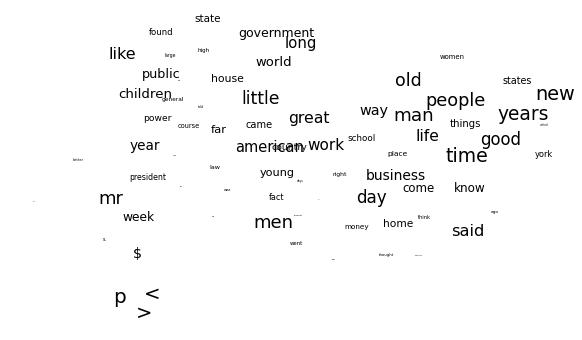

In [151]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [24]:
model=gensim.models.Word2Vec.load('../../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [25]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [26]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [27]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [28]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [29]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

### Data:
I'll be using magazine data pulled from the COHA dataset. A larger COHA file can be found in this directory, but for the purposes of this exercise I'll only use articles from 1950.

In [154]:
# Load data and tokenize/normalize
df = pandas.read_csv('coha.csv')
df = df.query('year == 1950')
df['tokenized_sents'] = df['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(str(x))])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
df[:100:10]

In [155]:
# Generate word2vec models
df_W2V = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sum())
df_W2V.save("coha_mag_1950_WORD2Vec")

In [393]:
print('american: \n {}'.format([i[0] for i in df_W2V.most_similar('american')]))
print('good: \n {}'.format([i[0] for i in df_W2V.most_similar('good')]))
print('work: \n {}'.format([i[0] for i in df_W2V.most_similar('work')]))
# df_W2V.wv.index2word
# df_W2V.most_similar('communists')
# df_W2V.most_similar('power')
# df_W2V.most_similar('free')
# df_W2V.most_similar('defense')
# df_W2V.most_similar('moscow') #interesting
# df_W2V.most_similar('nationalist')
# df_W2V.most_similar('threat') # interesting
# df_W2V.most_similar('anti') # interesting


american: 
 ['policy', 'western', 'europe', 'china', 'soviet', 'military', 'chinese', 'communist', 'korea', 'tobacco']
good: 
 ['work', 'know', 'moved', 'look', 'life', 'way', 'ahead', 'looking', 'higher', 'college']
work: 
 ['better', 'asked', 'business', 'way', 'moved', 'given', 'reached', 'experience', 'good', 'public']


### TNSE/PCA:
The graphs below show three versions of the TNSE projection using the top 60 words. The first uses 10 components, the second uses 25, and the third uses 55.

As the graphs show, there are some relatively stable groupings even with the lowest number of components. There are a few groups that dominate the semantic structure of the corpus, and possibly reveal something about the American mentality after World War II. These groups include World War II, communism, Russia, Korea, family, and work.
 

In [439]:
# Helper functions for plotting TNSE

def reduce_plot(nwords, ncomponents):
    targetWords = df_W2V.wv.index2word[3:nwords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(df_W2V[word])
    wordsSubMatrix = np.array(wordsSubMatrix)

    pcaWords = sklearn.decomposition.PCA(n_components = ncomponents).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    plot(tsneWords)

def plot(tsneWords):
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (nwords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()


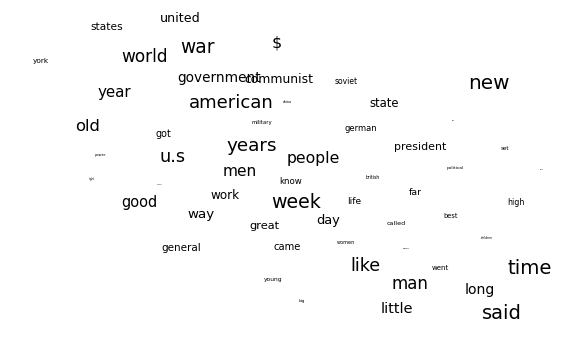

In [440]:
nwords = 60
ncomponents = 10
reduce_plot(nwords, ncomponents)

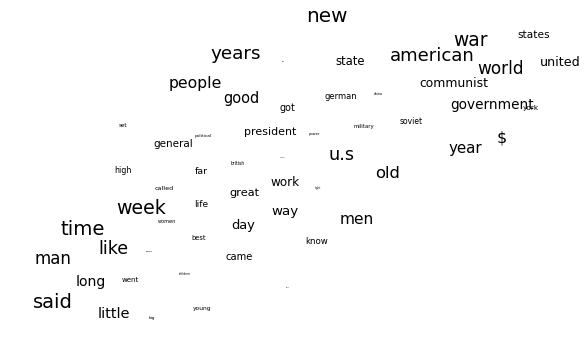

In [441]:
nwords = 60
ncomponents = 25
reduce_plot(nwords, ncomponents)

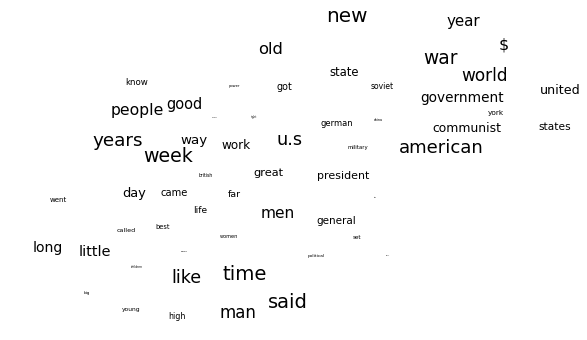

In [442]:
nwords = 60
ncomponents = 50
reduce_plot(nwords, ncomponents)

### Vectors, similar words, and analogies

Beyond the obvious dimensions of war and world power, work, time, and "good" are interesting dimensions to the structure.

The cells below show some similar words, starting with the word "good". We see this is associated with work, life, looking ahead, college, etc; all terms of an optimistic and growing American middle class.

In each graph, several words associated with time (week, years, day) appear close to the topic of "good", and thus "work". Further examination shows that these are related through wages, which makes sense. The top words again appear related to rising incomes: risen, worth, average, job, etc.

The model with the lowest number of components is arguably most representative of the overall semantic structure. Looking at the word "people", we see that it's very related to the world war grouping: aggression, information, russians, fighting, etc. As the number of components increase, the projection of this vector moves further away from the war grouping and closer to the work/week grouping.

In [449]:
df_W2V.most_similar('good')

[('work', 0.9997355937957764),
 ('know', 0.9997109770774841),
 ('moved', 0.9997090101242065),
 ('look', 0.9997057318687439),
 ('life', 0.9996896386146545),
 ('way', 0.9996744394302368),
 ('ahead', 0.9996575713157654),
 ('looking', 0.999651312828064),
 ('higher', 0.9996464252471924),
 ('college', 0.9996360540390015)]

In [450]:
df_W2V.most_similar('work')

[('better', 0.9997920989990234),
 ('asked', 0.9997825622558594),
 ('business', 0.9997800588607788),
 ('way', 0.9997782707214355),
 ('moved', 0.9997726678848267),
 ('given', 0.9997537732124329),
 ('reached', 0.9997427463531494),
 ('experience', 0.9997398853302002),
 ('good', 0.9997355937957764),
 ('public', 0.9997338056564331)]

In [451]:
df_W2V.most_similar('years')

[('months', 0.9982410669326782),
 ('risen', 0.9973658323287964),
 ('job', 0.9973252415657043),
 ('fashioned', 0.9973239302635193),
 ('annual', 0.99721759557724),
 ('taxes', 0.9971985816955566),
 ('nearly', 0.9971649646759033),
 ('cost', 0.9971497058868408),
 ('worth', 0.9971393346786499),
 ('average', 0.9971147179603577)]

In [452]:
df_W2V.most_similar('people')

[('possible', 0.9997947216033936),
 ('aggression', 0.9997943043708801),
 ('americans', 0.9997871518135071),
 ('information', 0.9997866153717041),
 ('russians', 0.9997835755348206),
 ('fighting', 0.9997833967208862),
 ('industrial', 0.9997802376747131),
 ('asian', 0.9997795820236206),
 ('parties', 0.9997777938842773),
 ('different', 0.9997736215591431)]

In the cell below we use analogies to extract American concerns about several countries. For the most part, the spread of communism was the dominant topic of the day.

In [453]:
print(df_W2V.doesnt_match(['russia', 'nationalism', 'communist']))
print(df_W2V.doesnt_match(['germany', 'nationalism', 'communist']))
print(df_W2V.doesnt_match(['japan', 'nationalism', 'communist']))
print(df_W2V.doesnt_match(['britain', 'nationalism', 'communist']))


communist
nationalism
communist
communist


## <span style="color:red">*End of exercise 1*</span>

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [454]:
apsDF = df#pandas.read_csv('../../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,Unnamed: 0,id,category,year,filename,text,tokenized_sents,normalized_sents
1971,1971,163027\n,MAG,1950,mag_1950_163027.txt,The Communist Party of Florence is flat broke ...,"[[The, Communist, Party, of, Florence, is, fla...","[[communist, party, florence, flat, broke], [w..."
1972,1972,163028\n,MAG,1950,mag_1950_163028.txt,Ever since the Allied Council for Japan was se...,"[[Ever, since, the, Allied, Council, for, Japa...","[[allied, council, japan, set, war, end, russi..."
1973,1973,163029\n,MAG,1950,mag_1950_163029.txt,The holiday season came to subequatorial South...,"[[The, holiday, season, came, to, subequatoria...","[[holiday, season, came, subequatorial, south,..."
1974,1974,163030\n,MAG,1950,mag_1950_163030.txt,Latin America will get extraordinary attention...,"[[Latin, America, will, get, extraordinary, at...","[[latin, america, extraordinary, attention, u...."
1975,1975,163031\n,MAG,1950,mag_1950_163031.txt,When shaggy-haired William Alexander Bustamant...,"[[When, shaggy, haired, William, Alexander, Bu...","[[shaggy, haired, william, alexander, bustaman..."
1976,1976,163032\n,MAG,1950,mag_1950_163032.txt,One of the more simptico of recent public figu...,"[[One, of, the, more, simptico, of, recent, pu...","[[simptico, recent, public, figures, argentina..."
1977,1977,163033\n,MAG,1950,mag_1950_163033.txt,""" This world will at last come into a time of ...","[[This, world, will, at, last, come, into, a, ...","[[world, come, time, peace, premier, alberta, ..."
1978,1978,163034\n,MAG,1950,mag_1950_163034.txt,As the silvery plane taxied to a stop on Rio '...,"[[As, the, silvery, plane, taxied, to, a, stop...","[[silvery, plane, taxied, stop, rio, santos, d..."
1979,1979,163035\n,MAG,1950,mag_1950_163035.txt,"Horatio Alger , his rags-to-riches message in ...","[[Horatio, Alger, his, rags, to, riches, messa...","[[horatio, alger, rags, riches, message, popul..."
1980,1980,163036\n,MAG,1950,mag_1950_163036.txt,It is said that famous men are usually the pro...,"[[It, is, said, that, famous, men, are, usuall...","[[said, famous, men, usually, product, unhappy..."


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [504]:
keywords = ['government',
'regime',
'communist',
'communism',
'democracy',
'democratic',
'nationalism',
'germany',
'britain',
'british',
'america',
'americans',
'china',
'chinese',
'men',
'women',
'job',
'work',
'good',
'bad',
'unemployment',
'unemployed',
'money']

In [498]:
# apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
# apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
apsDF['id'] = apsDF['id'].apply(lambda x: x[:-1])
apsDF['tokenized_words'] = apsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(str(x)))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [509]:


taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['year'])
    docKeywords.append(row['id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs


Now we can train a Doc2Vec model:

In [510]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/tjh/.virtualenvs/cca/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [511]:
apsD2V.docvecs[1952]

array([ 0.10133629, -0.2504883 , -0.4094129 , -0.07570784,  0.376612  ,
       -0.16602206,  0.37956047,  0.52719975,  0.40629578,  0.26561314,
        0.22290678, -0.496255  , -0.18152122,  0.45440564,  0.11239246,
       -0.00851813, -0.2609897 ,  0.08486681,  0.8826667 ,  0.04268678,
        0.17895225,  0.1342267 , -0.08471496,  0.04374268, -0.3604128 ,
        0.42651603, -0.18164946, -0.2024134 ,  0.15859191,  0.07578193,
       -0.14640932,  0.11878144, -0.2731927 ,  0.27059495, -0.09654606,
       -0.28521913, -0.2594483 ,  0.3370083 ,  0.68507105, -0.33248588,
       -0.04856722,  0.3798972 ,  0.7628462 , -0.49426118, -0.34697375,
        0.35739172,  0.8761216 ,  0.1524474 , -0.40289918, -0.4719891 ,
        0.6564704 ,  0.7060249 , -0.16816993,  0.27251405, -0.04021665,
        0.29748774,  0.835638  ,  0.13729435, -0.33117357,  0.97787094,
        0.0052257 ,  0.7233384 , -0.39615908, -0.39773068, -0.3368762 ,
       -0.75255936, -0.7241178 ,  0.19208188, -0.1076975 , -0.18

The words can still be accessed in the same way:

In [512]:
apsD2V['work']

array([ 0.11960092,  0.01508919,  0.4496248 ,  0.5584507 , -0.13485472,
        0.19810587, -0.00102073, -0.03327602, -0.4274684 , -0.42059192,
       -0.4363351 ,  0.2497602 ,  0.34456632,  0.17335945,  0.06072779,
        0.14520334,  0.6046788 ,  0.20759167, -0.7789377 ,  0.17256176,
        0.29456314, -0.09612995,  0.27117234, -0.23454227,  0.49143735,
       -0.52806246,  0.3121758 , -0.20213866, -0.12230013,  0.07669826,
        0.06069076,  0.01045035,  0.28846723,  0.08665636, -0.1008831 ,
        0.4601351 ,  0.41945183, -0.22697891, -0.51664215,  0.55830055,
       -0.04498296, -0.40119934, -0.8218612 ,  0.07190377,  0.5321632 ,
       -0.23662473, -0.2801676 , -0.21596883, -0.02597566,  0.5370055 ,
       -0.58229303, -0.39789233,  0.12658037, -0.0821289 ,  0.23120505,
       -0.33836776, -0.69176936,  0.00325596,  0.4256059 , -0.8444897 ,
        0.11241284, -0.70148456,  0.02477379,  0.42196113,  0.0972703 ,
        0.5800511 ,  0.69264656,  0.12365384, -0.14388174,  0.31

We can still use the ``most_similar`` command to perform simple semantic equations:

In [513]:
apsD2V.most_similar(positive = ['america','british'], negative = ['aid'], topn = 1)

[('published', 0.998550534248352)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [514]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('ranch', 0.9504481554031372)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [515]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

KeyError: "tag 'electron' not seen in training corpus/invalid"

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [517]:
apsD2V.docvecs.most_similar([ apsD2V['america'] ], topn=5 )

[('1894', 0.9841972589492798),
 ('1898', 0.9804619550704956),
 ('unemployed', 0.9770460724830627),
 ('1899', 0.9646263122558594),
 ('1904', 0.9575817584991455)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

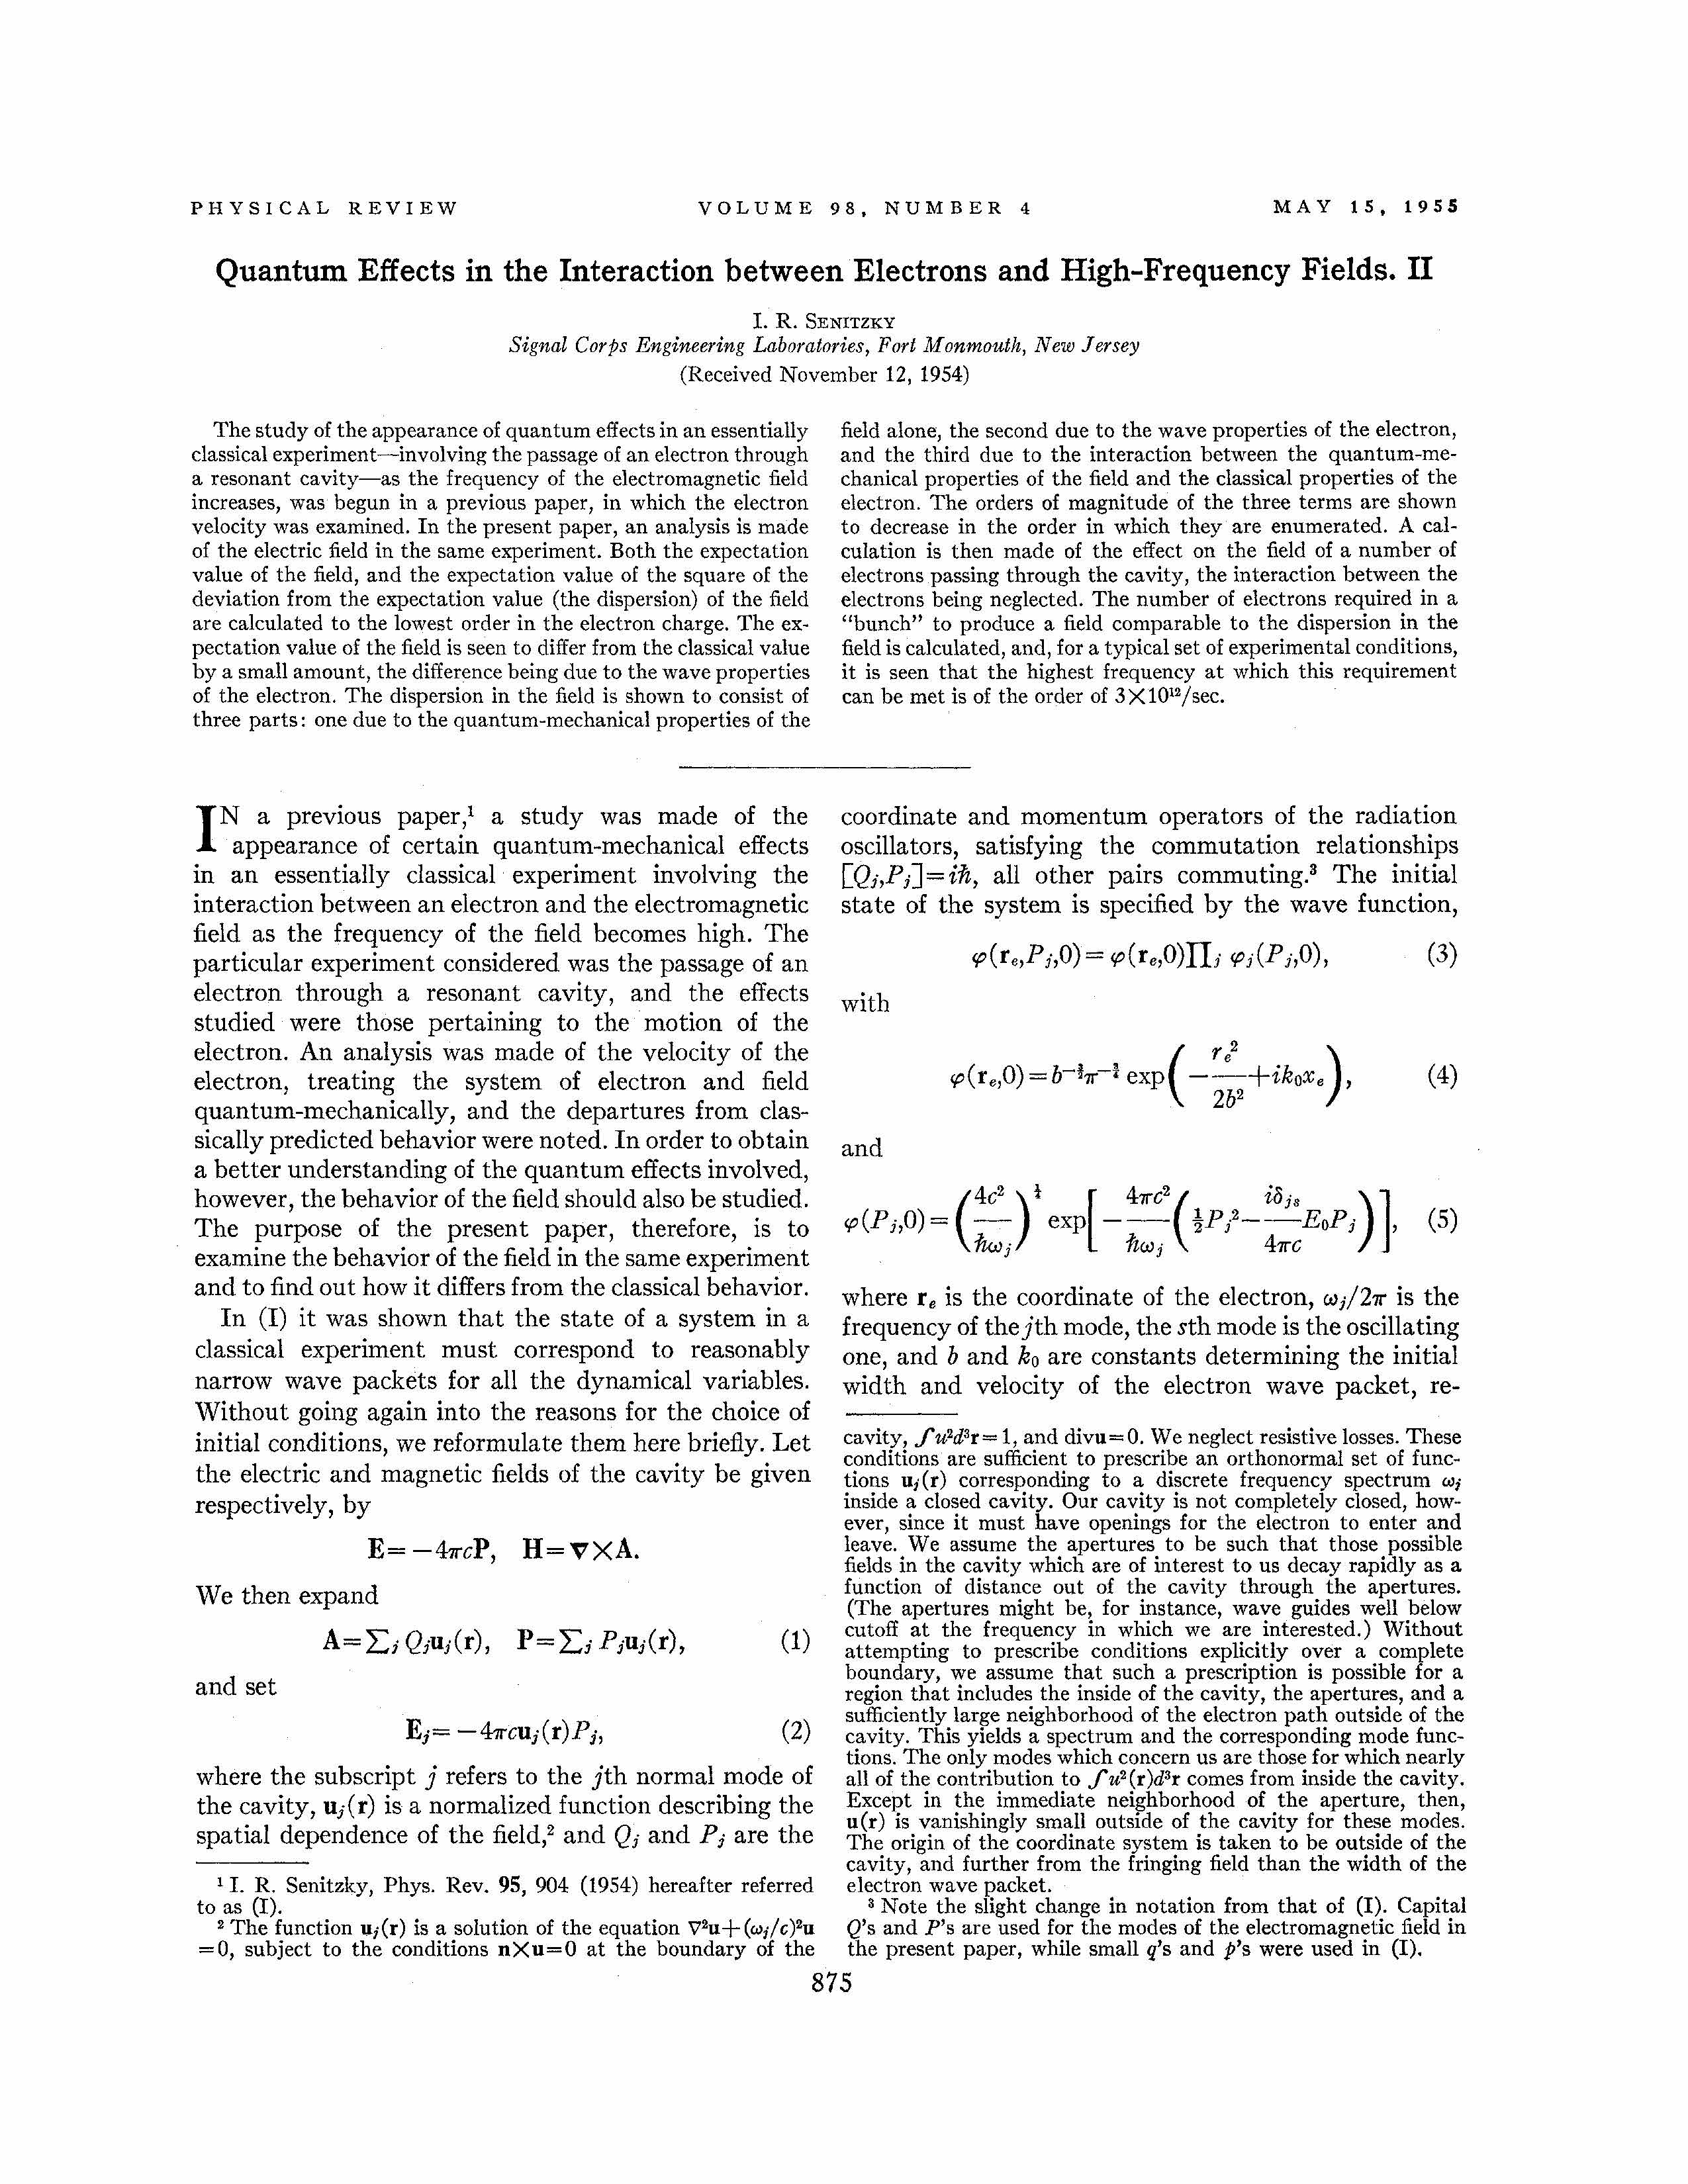

In [518]:
from IPython.display import Image
Image("../../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [519]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

KeyError: "tag '10.1103/PhysRev.98.875' not seen in training corpus/invalid"

We can even look for documents most like a query composed of multiple words:

In [520]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

KeyError: "tag 'electron' not seen in training corpus/invalid"

Now let's plot some words and documents against one another with a heatmap:

In [521]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

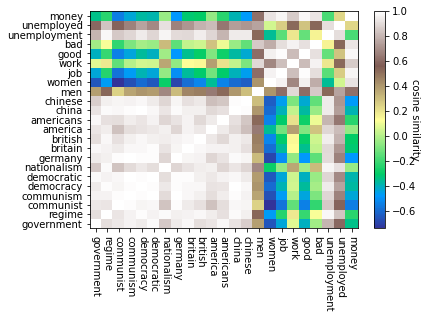

In [522]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [530]:
targetDocs = apsDF['id'][:100]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

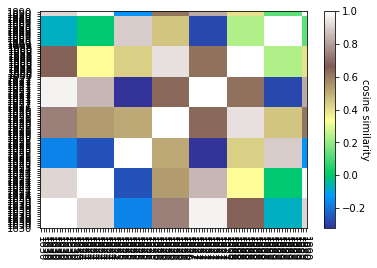

In [531]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [527]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

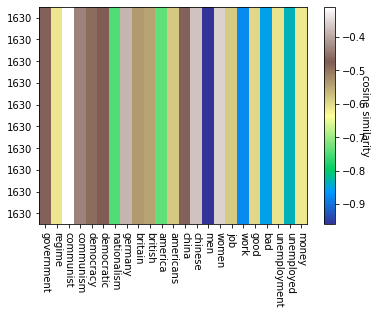

In [528]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [535]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

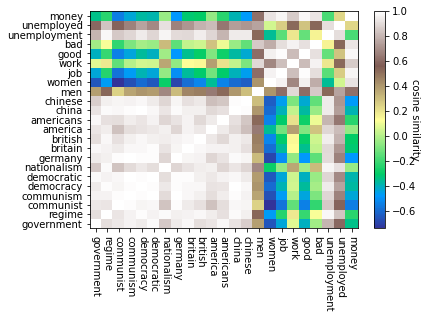

In [529]:
## Data reformatted to run through code above, repeating graphs

# Term similarity
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

The keyword similarity plot above reveals a strong association between the economic concepts discussed above, as well as unemployment and gender. At the intersection of these factors, we see that the tag "women" has a high similarity to the political terms and little similarity to the economic tags of work and money.

In [532]:
targetDocs = apsDF['id'][:100]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

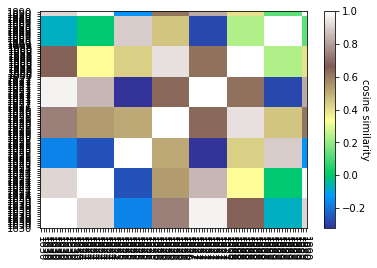

In [533]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

The document similarity plot of 100 articles above shows that our corpus has a decent amount of variability in topics and vocabulary. The corpus contains magazine articles covering a variety of topics (Hollywood, family, politics, etc), so this is expected.

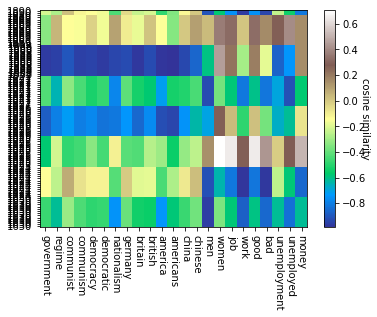

In [534]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

The document/topic similarity plot above shows that the keywords are broadly representative of corpus. There are some horizontal stripes that indicate a chunk of documents with little similarity to the words we've defined (see top of plot). Due to the ordering of the documents, we see some chunks of the dataframe that are highly similar to the political topics, indicating that these likely came from a political rather than lifestyle magazine.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [556]:
# nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../../data/nytimes_cbow.reduced.txt')
nytimes_model = gensim.models.word2vec.Word2Vec.load('apsW2V')

First we can visualize with dimension reduction

In [557]:
#words to create dimensions
tnytTargetWords = ['man','men', 'woman', 'women', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive', 'communism', 'communist', 'democracy', 'democratic', 'nationalism','nationalist']
#words we will be mapping
tnytTargetWords += ['america', 'germany', 'japan', 'korea', 'britain', 'france']


wordsSubMatrix = []
for word in tnytTargetWords:
    try:
        wordsSubMatrix.append(nytimes_model[word])
    except:
        pass
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [558]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 15).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

IndexError: index 22 is out of bounds for axis 0 with size 22

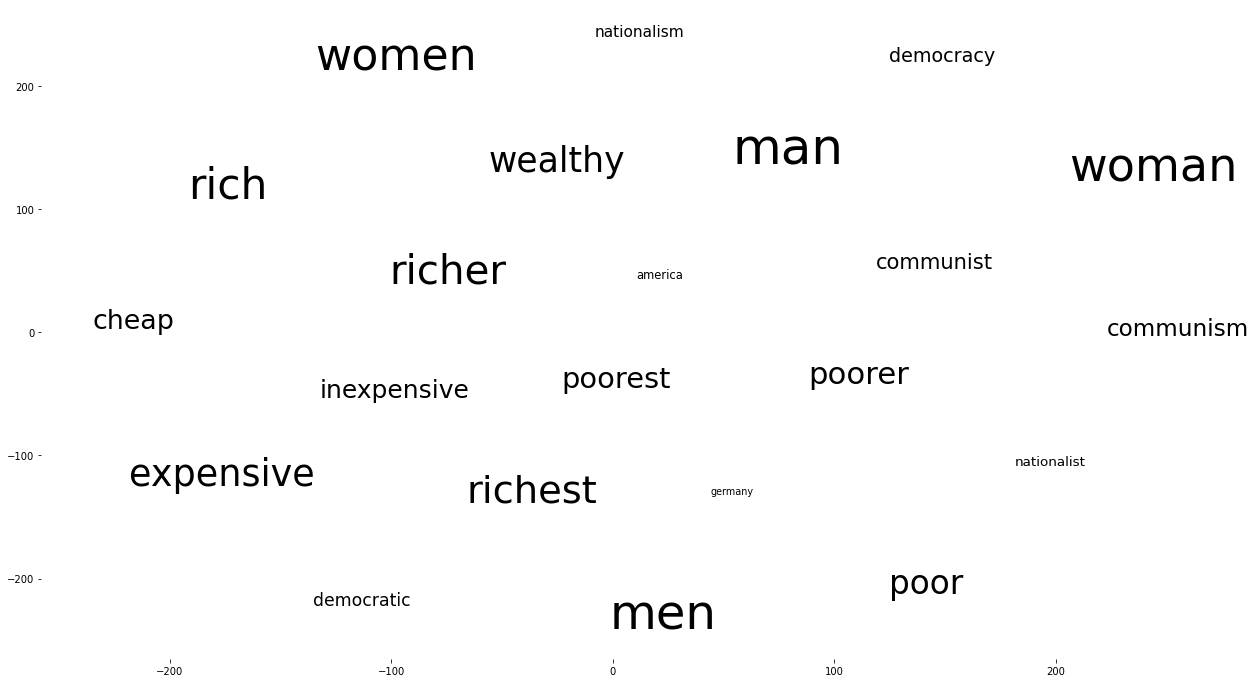

In [559]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    if i < 25:
        ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [560]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [567]:
Gender = dimension(nytimes_model, ['man','men'], ['woman', 'women'])
Race = dimension(nytimes_model, ['communism', 'communist','nationalism', 'nationalist'], ['democracy', 'democratic'])
Class = dimension(nytimes_model, ['rich', 'richest', 'expensive', 'wealthy'], ['poor', 'cheap'])

Here we have some words.

In [589]:
# Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]
Occupations =['america', 'germany', 'japan', 'korea', 'britain', 'france','china']
Foods = ['rural', 'urban', 'farm', 'city']

Sports  = ["manufacturing", "steel", "oil", "coal", "railroads", "farming", "agriculture"]

Define a function to project words in a word list to each of the three dimensions.

In [590]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'nation': g, 'locale': r, 'industry': c}, index = word_list)
    return df

Get the projections.

In [591]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [592]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

Using the code above, I created rough dimensions for three dimensions: gender, political system, and class. These dimensions are plotted below.  The first plot shows country names projected onto these dimensions. The ordering in this graph makes sense; America and Britain appear very close on all three axes, then Europe, then Asia.

The second graph attempts to map geographic/population features like urban/rural. Either the words I used to define the dimension were not sufficient or this is not a helpful perspective for my corpus. The ordering and proximity of the terms is unexplainable.

The third graph shows industrial/work activities. Surprisingly, we dont see similarity between related activities, like agriculture and farming. There is more meaningful separation than we saw with the urban/rural projection, though we will need to define the range of descriptors more carefully.

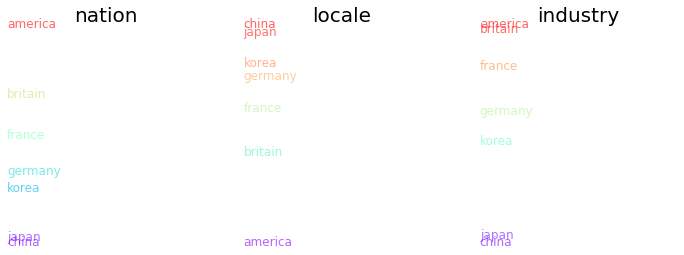

In [597]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'nation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'locale')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'industry')
plt.show()

Foods:

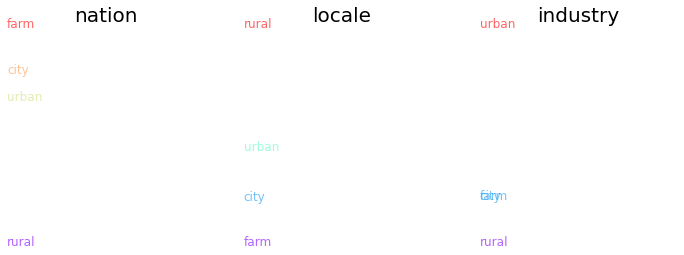

In [598]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'nation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'locale')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'industry')
plt.show()

Sports:

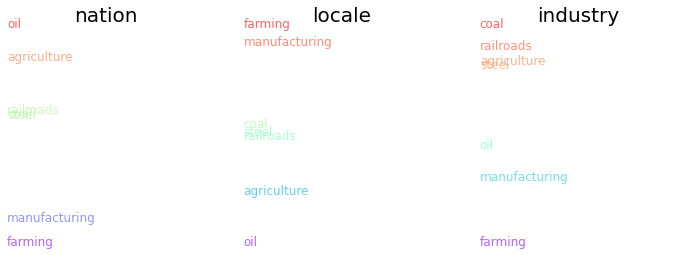

In [599]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'nation')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'locale')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'industry')
plt.show()

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [ ]:
import copy

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [ ]:
ascoDF = pandas.read_csv("../../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [ ]:
ascoDF

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [ ]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

The most divergent words are:

In [ ]:
wordDivergences[:20]

And the least:

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            token_sents = [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(coha_texts[article][2].decode("utf-8"))]
            normalized_sents = [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in token_sents]
            coha_df.loc[id_] = [year, genre, epoch, normalized_sents]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 
    
    
### Discourse Atom Model
    
The following code demonstrates a way to model topics using word embeddings, and is based on the paper: Discourses of Death: Introducing a new method to model topics in word embeddings," by Alina Arseniev-Koehler, Susan Cochran, Vickie Mays, and Jacob G. Foster. (Draft available upon request from May 15, 2020)
    
The code is included to demonstrate the technique.

In [ ]:
from __future__ import division
from gensim.models import Word2Vec
import pandas as pd
import cython
import gensim
import math
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
%matplotlib inline
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import boxplot 
from nltk.tokenize import word_tokenize
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_profiling
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
#from spellchecker import SpellChecker
from gensim.test.utils import datapath 
import re
import string, re
import cython

import numpy as np 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

#some of these not needed, clean up last step

In [ ]:
# w2vmodel = Word2Vec.load('embedding_genre_fic')
w2vmodel = KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin", limit=25730, binary=True)

In [ ]:
#len(w2vmodel.wv.vocab) #vocabulary size (recall that words had to be included at least 10x to be in this model)
#w2vmodel.wv.most_similar('she', topn=25) 

In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='../../data/aksvd_models/'): #set for Alina's files, switch to where you want save the model
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

* Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another; we want a balance between these two. 

In [ ]:
#reconstruction quality, including R^2:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)

def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)


Usage example

In [ ]:
dictionary, alpha = do_aksvd(w2vmodel, 150, 5, save=True)

In [ ]:
topic_diversity(w2vmodel, dictionary, top_n=25)

In [ ]:
reconst_qual(w2vmodel, dictionary, alpha)

**Explore a Trained Discourse Atom Topic Model**

In [ ]:
#loading back in the model pieces if not already in

infile = open('../../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('../../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('../../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

For each atom, look at the most similar words.

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')
    
#for a specific atom, e.g., 112th atom look at 25 most similar words:
#w2vmodel.wv.similar_by_vector(dictionary[112],topn=25)

Look at how a word "loads" onto atoms, based on the nonzeros (i.e., alpha)

In [ ]:
print(w2vmodel.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])

#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0